In [18]:
# RANDOM FOREST CLASSIFIER

# Import all the packages needed

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from itertools import chain
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# Import the cleaned data set

from google.colab import files
files.upload()

Saving Cleaned_Dataset.csv to Cleaned_Dataset.csv


In [3]:
# Load the cleaned data set

df = pd.read_csv('Cleaned_Dataset.csv')
df = df[['target', 'tweet']]

df.head()

target                                              tweet
0       0          aw bummer get david car third day it good
1       0  upset update facebok texting it cry result sch...
2       0      dive many time ball manage save rest go bound
3       0                    whole body feel itchy like fire
4       0                   no behave all mad here see there

In [4]:
df['body_len'] = df['tweet'].apply(lambda x: len(x) - x.count(" "))
df.head()

target                                              tweet  body_len
0       0          aw bummer get david car third day it good        33
1       0  upset update facebok texting it cry result sch...        55
2       0      dive many time ball manage save rest go bound        37
3       0                    whole body feel itchy like fire        26
4       0                   no behave all mad here see there        26

In [5]:

df.shape

(1593253, 3)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1593253 entries, 0 to 1593252
Data columns (total 3 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   target    1593253 non-null  int64 
 1   tweet     1593253 non-null  object
 2   body_len  1593253 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 36.5+ MB


In [16]:
# check the number of positive vs. negative tagged sentences
positives = df['target'][df.target == 1 ]
negatives = df['target'][df.target == 0 ]

print('Total length of the data is:         {}'.format(df.shape[0]))
print('No. of positve tagged sentences is:  {}'.format(len(positives)))
print('No. of negative tagged sentences is: {}'.format(len(negatives)))

Total length of the data is:         1593253
No. of positve tagged sentences is:  796317
No. of negative tagged sentences is: 796936


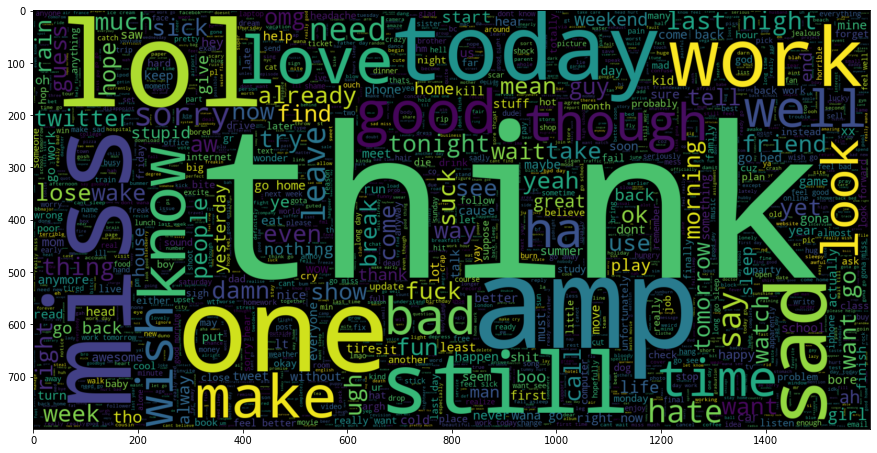

In [17]:
# generating word cloud for negative words


from wordcloud import WordCloud

plt.figure(figsize = (15,15)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.target == 0].tweet))
plt.imshow(wc , interpolation = 'bilinear')

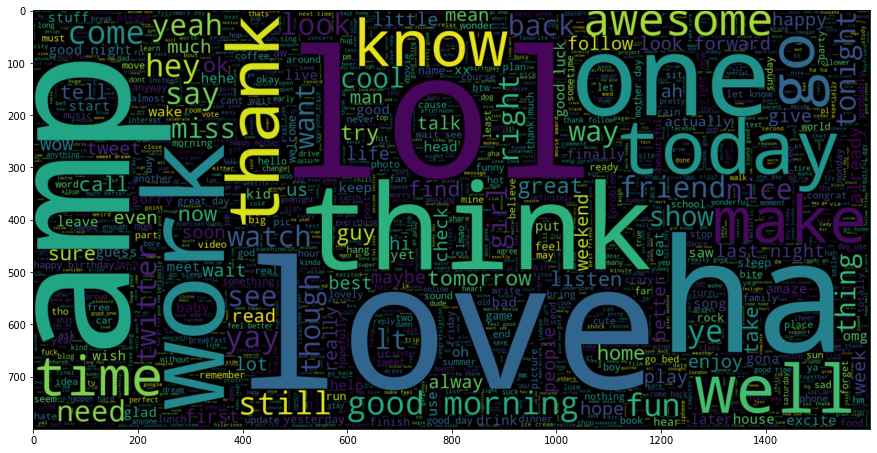

In [19]:
# generating word cloud for positive words

plt.figure(figsize = (15,15)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.target == 1].tweet))
plt.imshow(wc , interpolation = 'bilinear')

In [20]:

# get a word count per of text

def word_count(words):
    return len(words.split())

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


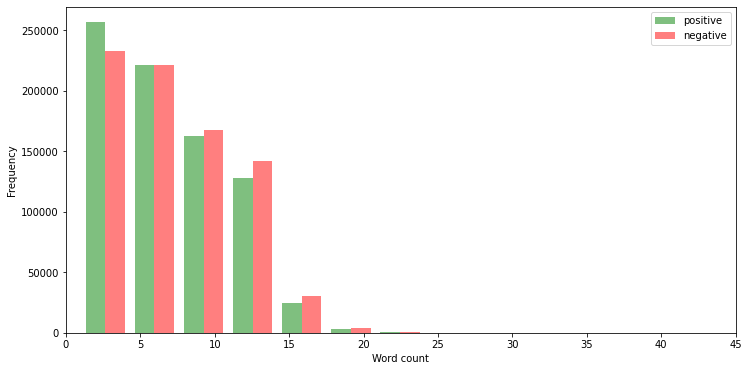

In [21]:
# plot word count distribution for both positive and negative 

df['word count'] = df['tweet'].apply(word_count)
p = df['word count'][df.target == 1]
n = df['word count'][df.target == 0]
plt.figure(figsize=(12,6))
plt.xlim(0,45)
plt.xlabel('Word count')
plt.ylabel('Frequency')
g = plt.hist([p, n], color=['g','r'], alpha=0.5, label=['positive','negative'])
plt.legend(loc='upper right')

In [6]:
# Splitting the training and test data sets

X_train, X_test, y_train, y_test = train_test_split(df['tweet'], df['target'], test_size=0.25, random_state=42)

In [7]:
# Feature extraction

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
vectorizer = TfidfVectorizer(min_df=10, ngram_range=(1, 3))
vectorizer.fit(X_train)      
x_tr = vectorizer.transform(X_train)
x_te = vectorizer.transform(X_test)

print(f'Vector fitted.')
print('No. of feature_words: ', len(vectorizer.get_feature_names()))

Vector fitted.
No. of feature_words:  117214


In [13]:
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(x_te)

    # Print the evaluation metrics for the dataset.
    print("Performance Report: ")
    print("---------------------")
    print(classification_report(y_test, y_pred))
    print('\n\n')

    print("Confusion Matrix: ")
    print("---------------------")
    cf_matrix = confusion_matrix(y_test, y_pred)
    print('conf',cf_matrix)

    print('\n\n')

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
    plt.show()
    plt.savefig('confusionMatrix')

Performance Report: 
---------------------
              precision    recall  f1-score   support

           0       0.75      0.67      0.71    198669
           1       0.70      0.77      0.74    199645

    accuracy                           0.72    398314
   macro avg       0.72      0.72      0.72    398314
weighted avg       0.72      0.72      0.72    398314




Confusion Matrix: 
---------------------
conf [[133088  65581]
 [ 44980 154665]]





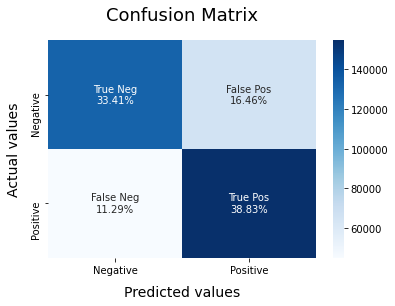

<Figure size 432x288 with 0 Axes>

In [14]:
# Evaluate the model

rf = RandomForestClassifier(n_estimators = 20, criterion = 'entropy', max_depth=50,random_state=42)
rf.fit(x_tr, y_train)
model_Evaluate(rf)